# INTRO - VGG16 Transfer Learning


In this notebook I use the pretraiened wieghts of VGG16 and imagenet to classify images of fruits. To increase the generalisation of the model, appropriate data augumentation is applied.


The Data used is from the Fruit 360 datset competition in Kaggle:
https://www.kaggle.com/moltean/fruits#32_100.jpg

Additionaly, I make predictions on new data downloaded from the internet.





## Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# import keras

pd.set_option('display.max_columns', None, 'display.max_rows', 100)

In [0]:
# Imports for the Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import sys, os

from tensorflow.keras.models import load_model

In [0]:
from sklearn.utils import shuffle

## Check the data

In [21]:
cd /content/drive/My Drive/Colab Notebooks/fruits-360/fruits-small

/content/drive/My Drive/Colab Notebooks/fruits-360/fruits-small


In [22]:
!ls


Fruit4.h5	    Lime_Single.jpeg   Real_Test	       Testing
history_Fruit4.csv  ORANGE_SINGLE.jpg  results_fruit360-4.csv  Training


In [23]:
!ls Testing

Clementine  Limes  Mandarine  Orange


In [24]:
!ls Training

Clementine  Limes  Mandarine  Orange


In [25]:
!ls Real_Test/

Clementine  Lime  Mandrarine  Orange


In [0]:
# plt.imshow(image.load_img('Training/Mandarine/145_100.jpg'))
# plt.show()

In [0]:
train_path = 'Training'
valid_path = 'Testing'
test_path = 'Real_Test'

In [0]:
# Make all images one size
IMAGE_SIZE = [200, 200]

In [0]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')
test_images = glob(test_path + '/*/*.jpg')

In [31]:
# useful for getting number of classes
folders = glob(train_path + '/*')
len(folders)

4

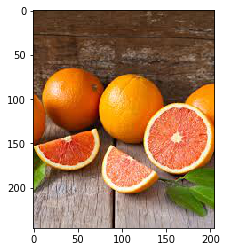

In [16]:
# look at a test set image
plt.imshow(image.load_img(np.random.choice(test_images)))
plt.show()

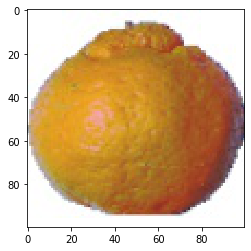

In [32]:
# look at a valid set image
plt.imshow(image.load_img(np.random.choice(valid_image_files)))
plt.show()

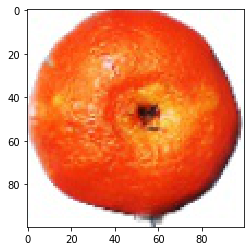

In [33]:
# look at a train set image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

#Building the Model

In [34]:
# Take the weights without the final layer - we want to attached our own head
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False
)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
# freeze pretrained model weights
ptm.trainable = False

In [0]:
# map the data into feature vectors
# Keras image data generator returns classes one-hot encoded

K = len(folders)
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

In [0]:
model = Model(inputs = ptm.input, outputs=x)

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [0]:
# Create an instance of ImageDataGenerator
gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
    # Important to get all the images preprocessed to the format expected by the 
    # pretrained model  
  preprocessing_function=preprocess_input
)

# Only in the training set the data is augumented
gen_valid = ImageDataGenerator(
    # Important to get all the images preprocessed to the format expected by the 
    # pretrained model  
  preprocessing_function=preprocess_input
)

In [0]:
#Test Generator
gen_test = ImageDataGenerator(
    # Important to get all the images preprocessed to the format expected by the 
    # pretrained model  
  preprocessing_function=preprocess_input
)

In [44]:
batch_size = 128

# create generators
train_generator = gen_train.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
)

valid_generator = gen_valid.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
)

test_generator = gen_test.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=1,
)


Found 1949 images belonging to 4 classes.
Found 658 images belonging to 4 classes.
Found 9 images belonging to 4 classes.


In [0]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [30]:
r = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs = 5,
    steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
    validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),    
)

# Save the model
model.save('Fruit4.h5')

# Save the history
history = pd.DataFrame(r.history)
history.to_csv('history_Fruit4.csv', index=False)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 16 steps, validate for 6 steps
Epoch 1/5
16/16 [==============================] - 810s 51s/step - loss: 2.4637 - accuracy: 0.8707 - val_loss: 3.4392e-05 - val_accuracy: 1.0000
Epoch 2/5
16/16 [==============================] - 20s 1s/step - loss: 2.9877e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
16/16 [==============================] - 20s 1s/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
16/16 [==============================] - 20s 1s/step - loss: 1.5673e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
16/16 [==============================] - 20s 1s/step - loss: 0.0095 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


# Performance analysis

In [0]:
# Later on
model = load_model('Fruit4.h5')
history = pd.read_csv('history_Fruit4.csv')

In [46]:
evaluation = model.evaluate_generator(generator=valid_generator,
                         steps=int(np.ceil(len(valid_image_files) / batch_size)))
print(evaluation)
print(model.metrics_names)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
[0.0, 1.0]
['loss', 'accuracy']


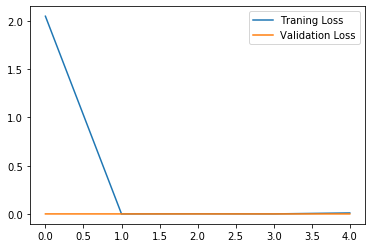

In [49]:
plt.plot(history['loss'], label='Traning Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

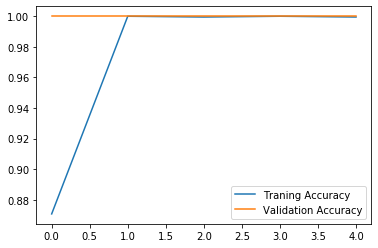

In [50]:
plt.plot(history['accuracy'], label='Traning Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [51]:
# Prediction on a test set from the Internet
test_generator.reset()
pred = model.predict_generator(test_generator,
)
predicted_class_indices = np.argmax(pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [52]:
# Get class labels and assign them to the predicted indices
labels = (train_generator.class_indices)
labels_dict = dict((v, k) for k, v in labels.items())
predictions = [labels_dict[k] for k in predicted_class_indices]
predictions

['Mandarine',
 'Clementine',
 'Mandarine',
 'Orange',
 'Clementine',
 'Limes',
 'Limes',
 'Limes',
 'Mandarine']

In [0]:
filenames=test_generator.filenames
results = pd.DataFrame({'Filename': filenames,
                        'Predictions': predictions})
results.to_csv('results_fruit360-4.csv', index=False)

That is the result

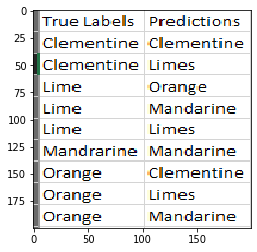

In [54]:
img = image.load_img('Results_real_test.PNG', target_size=IMAGE_SIZE)
plt.imshow(img)
plt.show()

Try to predict a single Photo

In [0]:
img = image.load_img('Lime_Single.jpeg', target_size=IMAGE_SIZE)

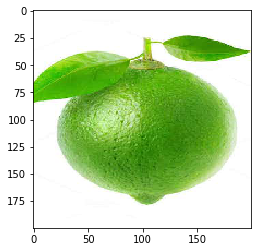

In [91]:
plt.imshow(img)
plt.show()

In [56]:
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
x = preprocess_input(img)
single_prediction = model.predict(x)
single_prediction = np.argmax(single_prediction, axis=1)
single_prediction

single_prediction = [labels_dict[k] for k in single_prediction]
print(single_prediction)

['Limes']


In [0]:
# Well this time its correct

# Summary

*   The model performs supereb on the validation set
*   The model performs very bad on random pictures from the internet
*   The model recognized a single picture with a similar look to those in the train/ validation set

The problem with this model was the different distribution of real data and these of the training and validation set. 

The take away is - train a model on a data with distribution as close as possible to the one you are going to apply the model later on!



